In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import date
from pandas import DataFrame
warnings.filterwarnings('ignore')
%matplotlib inline 
sns.set(color_codes=True)
from sklearn import preprocessing
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, rand_score
from sklearn.decomposition import PCA
from sklearn import metrics

In [2]:
delitos_2020 = pd.read_csv('delitos_2020.csv')
delitos_2019 = pd.read_csv('delitos_2019.csv')

In [3]:
delitos_2020.dtypes

id_mapa       object
anio           int64
mes           object
dia           object
fecha         object
franja        object
tipo          object
subtipo       object
uso_armas     object
barrio        object
comuna       float64
latitud      float64
longitud     float64
victimas     float64
dtype: object

In [4]:
delitos_2019.dtypes

id                       int64
fecha                   object
franja_horaria          object
tipo_delito             object
subtipo_delito          object
cantidad_registrada    float64
comuna                 float64
barrio                  object
lat                    float64
long                   float64
dtype: object

In [5]:
print(f'Shape: {np.shape(delitos_2020)}')
delitos_2020.head(3)

Shape: (66714, 14)


,id_mapa,anio,mes,dia,fecha,franja,tipo,subtipo,uso_armas,barrio,comuna,latitud,longitud,victimas
0,HC-2020-0007157,2020,Enero,Sábado,04/01/2020,10,Homicidio,Siniestro Vial,NaN,Villa Crespo,15.0,-34.592133,-58.439106,1.0
1,HC-2020-0009055,2020,Enero,Domingo,05/01/2020,20,Homicidio,Siniestro Vial,NaN,Flores,7.0,-34.646459,-58.450195,1.0
2,HC-2020-0022499,2020,Enero,Sábado,11/01/2020,6,Homicidio,Siniestro Vial,NaN,Balvanera,3.0,-34.609272,-58.393379,1.0


In [6]:
print(f'Shape: {np.shape(delitos_2019)}')
delitos_2019.head(3)

Shape: (122484, 10)


,id,fecha,franja_horaria,tipo_delito,subtipo_delito,cantidad_registrada,comuna,barrio,lat,long
0,1038983,13-09-19,14,Robo (con violencia),NaN,NaN,6.0,Caballito,-34.609876,-58.456159
1,1038986,13-09-19,16,Robo (con violencia),NaN,NaN,3.0,Balvanera,-34.609394,-58.395934
2,1038989,13-09-19,13,Robo (con violencia),NaN,NaN,3.0,Balvanera,-34.609231,-58.411177


Renombramos columnas para luego poder concatenar ambos Datasets en uno solo.

In [7]:
delitos_2020 = delitos_2020.rename(columns={'franja':'franja_horaria'})

In [8]:
delitos_2019 = delitos_2019.rename(columns={'tipo_delito':'tipo',
                                           'subtipo_delito':'subtipo',
                                           'lat':'latitud',
                                           'long':'longitud',
                                           'cantidad_registrada':'victimas'})

In [9]:
delitos_total = pd.concat([delitos_2020,delitos_2019],
                                  axis = 0, 
                                  join = "inner", 
                                  ignore_index = False)
delitos_total.head(-3)

,fecha,franja_horaria,tipo,subtipo,barrio,comuna,latitud,longitud,victimas
0,04/01/2020,10,Homicidio,Siniestro Vial,Villa Crespo,15.0,-34.592133,-58.439106,1.0
1,05/01/2020,20,Homicidio,Siniestro Vial,Flores,7.0,-34.646459,-58.450195,1.0
2,11/01/2020,6,Homicidio,Siniestro Vial,Balvanera,3.0,-34.609272,-58.393379,1.0
3,14/01/2020,6,Homicidio,Siniestro Vial,San Cristóbal,3.0,-34.624766,-58.410372,1.0
4,14/01/2020,21,Homicidio,Siniestro Vial,Monserrat,1.0,-34.609303,-58.390526,1.0
...,...,...,...,...,...,...,...,...,...
122476,13-09-19,21,Robo (con violencia),NaN,Caballito,6.0,-34.613917,-58.440915,NaN
122477,13-09-19,4,Robo (con violencia),NaN,Balvanera,3.0,-34.613823,-58.391717,NaN
122478,13-09-19,9,Robo (con violencia),NaN,San Cristóbal,3.0,-34.622990,-58.401106,NaN
122479,13-09-19,21,Robo (con violencia),NaN,Vélez Sársfield,10.0,-34.631202,-58.500760,NaN


In [10]:
#Veremos el porcentaje de nulos que tiene cada columna
total_na = ((delitos_total.isnull().sum() / len(delitos_total))*100).sort_values(ascending = False)
print(total_na)

victimas          94.453430
subtipo           89.477690
barrio             0.582987
comuna             0.582987
latitud            0.582987
longitud           0.582987
fecha              0.000000
franja_horaria     0.000000
tipo               0.000000
dtype: float64


Eliminaremos las columnas victimas y subtipo ya que en su mayoría están compuestas por nulos. Además, eliminaremos los registros que tengan nulos en barrio, comuna, latitud y longitud.

In [11]:
delitos_total.drop(['victimas', 'subtipo'], axis = 'columns', inplace=True)
delitos_total.head(-3)

,fecha,franja_horaria,tipo,barrio,comuna,latitud,longitud
0,04/01/2020,10,Homicidio,Villa Crespo,15.0,-34.592133,-58.439106
1,05/01/2020,20,Homicidio,Flores,7.0,-34.646459,-58.450195
2,11/01/2020,6,Homicidio,Balvanera,3.0,-34.609272,-58.393379
3,14/01/2020,6,Homicidio,San Cristóbal,3.0,-34.624766,-58.410372
4,14/01/2020,21,Homicidio,Monserrat,1.0,-34.609303,-58.390526
...,...,...,...,...,...,...,...
122476,13-09-19,21,Robo (con violencia),Caballito,6.0,-34.613917,-58.440915
122477,13-09-19,4,Robo (con violencia),Balvanera,3.0,-34.613823,-58.391717
122478,13-09-19,9,Robo (con violencia),San Cristóbal,3.0,-34.622990,-58.401106
122479,13-09-19,21,Robo (con violencia),Vélez Sársfield,10.0,-34.631202,-58.500760


In [12]:
delitos_total = delitos_total[delitos_total['barrio'].notna()]

In [13]:
total_na = ((delitos_total.isnull().sum() / len(delitos_total))*100).sort_values(ascending = False)
print(total_na)

fecha             0.0
franja_horaria    0.0
tipo              0.0
barrio            0.0
comuna            0.0
latitud           0.0
longitud          0.0
dtype: float64


Quitaremos los duplicados debido a que un mismo delito no debería estar cargado dos veces en el Dataset. Asimismo, efectuaremos cambios (como caracteres, tipos de datos) que nos permitan conseguir homogeneidad en los datos.

In [14]:
delitos_total.drop_duplicates(inplace=True,keep='first')
print(f'Shape: {np.shape(delitos_total)}')

Shape: (186930, 7)


In [15]:
delitos_total.fecha = delitos_total['fecha'].replace("-", "/", regex=True)
delitos_total.fecha = delitos_total['fecha'].replace("/19","/2019",regex=True)
delitos_total.barrio = delitos_total['barrio'].replace("á", "A", regex=True)
delitos_total.barrio = delitos_total['barrio'].replace("é", "E", regex=True)
delitos_total.barrio = delitos_total['barrio'].replace("í", "I", regex=True)
delitos_total.barrio = delitos_total['barrio'].replace("ó", "O", regex=True)
delitos_total.barrio = delitos_total['barrio'].replace("ú", "U", regex=True)
delitos_total['barrio'] = delitos_total['barrio'].str.upper()

In [16]:
delitos_total.head(-3)

,fecha,franja_horaria,tipo,barrio,comuna,latitud,longitud
0,04/01/2020,10,Homicidio,VILLA CRESPO,15.0,-34.592133,-58.439106
1,05/01/2020,20,Homicidio,FLORES,7.0,-34.646459,-58.450195
2,11/01/2020,6,Homicidio,BALVANERA,3.0,-34.609272,-58.393379
3,14/01/2020,6,Homicidio,SAN CRISTOBAL,3.0,-34.624766,-58.410372
4,14/01/2020,21,Homicidio,MONSERRAT,1.0,-34.609303,-58.390526
...,...,...,...,...,...,...,...
122476,13/09/2019,21,Robo (con violencia),CABALLITO,6.0,-34.613917,-58.440915
122477,13/09/2019,4,Robo (con violencia),BALVANERA,3.0,-34.613823,-58.391717
122478,13/09/2019,9,Robo (con violencia),SAN CRISTOBAL,3.0,-34.622990,-58.401106
122479,13/09/2019,21,Robo (con violencia),VELEZ SARSFIELD,10.0,-34.631202,-58.500760


In [17]:
delitos_total = delitos_total.reset_index()

In [18]:
delitos_total.drop(['index'], axis = 'columns', inplace=True)
delitos_total.head(-3)

,fecha,franja_horaria,tipo,barrio,comuna,latitud,longitud
0,04/01/2020,10,Homicidio,VILLA CRESPO,15.0,-34.592133,-58.439106
1,05/01/2020,20,Homicidio,FLORES,7.0,-34.646459,-58.450195
2,11/01/2020,6,Homicidio,BALVANERA,3.0,-34.609272,-58.393379
3,14/01/2020,6,Homicidio,SAN CRISTOBAL,3.0,-34.624766,-58.410372
4,14/01/2020,21,Homicidio,MONSERRAT,1.0,-34.609303,-58.390526
...,...,...,...,...,...,...,...
186922,13/09/2019,21,Robo (con violencia),CABALLITO,6.0,-34.613917,-58.440915
186923,13/09/2019,4,Robo (con violencia),BALVANERA,3.0,-34.613823,-58.391717
186924,13/09/2019,9,Robo (con violencia),SAN CRISTOBAL,3.0,-34.622990,-58.401106
186925,13/09/2019,21,Robo (con violencia),VELEZ SARSFIELD,10.0,-34.631202,-58.500760


In [19]:
delitos_total.dtypes

fecha              object
franja_horaria     object
tipo               object
barrio             object
comuna            float64
latitud           float64
longitud          float64
dtype: object

Veremos los valores únicos que tiene la columna de franja_horaria a fin de que, en caso de haber valores no numéricos, podamos eliminarlos para pasar a un tipo de dato datetime

In [20]:
delitos_total["franja_horaria"].unique()

array(['10', '20', '6', '21', '12', '0', '7', '5', '11', '2', '14', '13',
       '23', '17', '16', '8', '15', '3', '18', '4', '19', '1', '22', '9',
       'SD', 'sd', 12, 8, 10, 23, 17, 9, 15, 7, 11, 22, 3, 14, 20, 1, 18,
       6, 0, 5, 13, 19, 21, 16, 4, 2, 'S/D'], dtype=object)

In [21]:
delitos_total = delitos_total.astype({"franja_horaria": str})

In [22]:
SD = delitos_total["franja_horaria"].value_counts()
print(SD)

0      12166
18     11036
19     10996
20     10765
12     10218
17     10044
16      9933
14      9854
15      9522
21      9454
13      9320
10      8905
11      8864
22      8090
9       7919
8       7806
23      6602
7       5597
6       4303
1       3679
5       3408
2       2838
4       2579
3       2546
SD       481
S/D        4
sd         1
Name: franja_horaria, dtype: int64


In [23]:
delitos_total = delitos_total.drop(delitos_total[delitos_total['franja_horaria']=="sd"].index)
delitos_total = delitos_total.drop(delitos_total[delitos_total['franja_horaria']=="S/D"].index)
delitos_total = delitos_total.drop(delitos_total[delitos_total['franja_horaria']=="SD"].index)
SD = delitos_total["franja_horaria"].value_counts()
print(SD)

0     12166
18    11036
19    10996
20    10765
12    10218
17    10044
16     9933
14     9854
15     9522
21     9454
13     9320
10     8905
11     8864
22     8090
9      7919
8      7806
23     6602
7      5597
6      4303
1      3679
5      3408
2      2838
4      2579
3      2546
Name: franja_horaria, dtype: int64


Creamos las columnas de mes y año para utilizarlas, posteriormente, en varios gráficos.

In [24]:
delitos_total['mesaño'] = delitos_total['fecha'].str[3:]
delitos_total['mes'] = delitos_total['fecha'].str[3:5]
delitos_total['dia'] = delitos_total['fecha'].str[8:]
delitos_total = delitos_total.sort_values(by='mesaño') 

In [25]:
delitos_total['año'] = delitos_total['fecha'].str[6:]
delitos_total = delitos_total.astype({"franja_horaria": int})
delitos_total = delitos_total.astype({"comuna": int})
#delitos_total = delitos_total['tipo'].astype('str')

delitos_total.dtypes

fecha              object
franja_horaria      int32
tipo               object
barrio             object
comuna              int32
latitud           float64
longitud          float64
mesaño             object
mes                object
dia                object
año                object
dtype: object

In [26]:
delitos_total.head()

,fecha,franja_horaria,tipo,barrio,comuna,latitud,longitud,mesaño,mes,dia,año
81926,25/01/2019,11,Robo (con violencia),PARQUE PATRICIOS,4,-34.636791,-58.403786,01/2019,01,19,2019
71939,18/01/2019,8,Robo (con violencia),RECOLETA,2,-34.592514,-58.404175,01/2019,01,19,2019
71940,18/01/2019,15,Robo (con violencia),CHACARITA,15,-34.590628,-58.448602,01/2019,01,19,2019
71941,18/01/2019,2,Robo (con violencia),PARQUE CHAS,15,-34.588924,-58.478135,01/2019,01,19,2019
71942,18/01/2019,2,Robo (con violencia),PARQUE CHAS,15,-34.588848,-58.484470,01/2019,01,19,2019


# E.D.A (ANÁLISIS EXPLORATORIO DE DATOS)

# Delitos vs Tiempo

- Comparación entre las distribuciones de los delitos ocurridos en 2019 y 2020 por franja horaria. (GRÁFICA DE DISTRIBUCIÓN)
- Creación de la gráfica de distribución con ambos datasets complementada con su correspondiente histograma por franja horaria. (GRÁFICA DE DISTRIBUCIÓN)
- Comparación de la cantidad de delitos ocurridos entre 2019 y 2020. (GRÁFICO DE BARRAS)
- Comparación de la cantidad de delitos mes a mes ocurridos entre 2019 y 2020. (GRÁFICO DE BARRAS)


In [27]:
groups = delitos_total.groupby(delitos_total.año)
dl_2019 = groups.get_group("2019")
dl_2020=groups.get_group("2020")

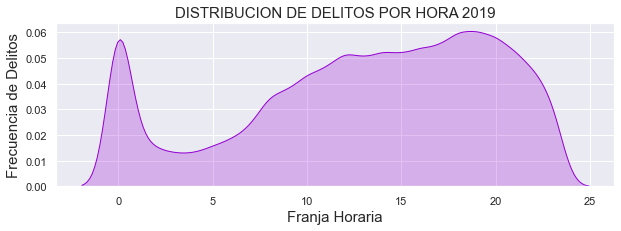

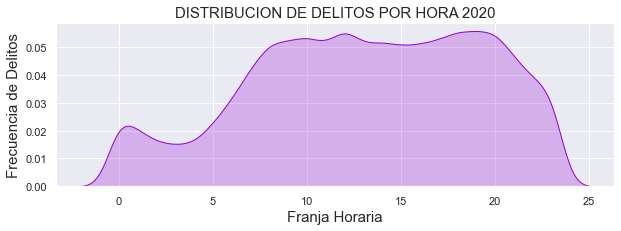

In [28]:
plt.figure(figsize=(10,3))
sns.kdeplot(dl_2019['franja_horaria'], color= "darkviolet", shade = True)
plt.xlabel("Franja Horaria",size = 15)
plt.ylabel("Frecuencia de Delitos",size = 15)
plt.title('DISTRIBUCION DE DELITOS POR HORA 2019',size = 15)
plt.show()

plt.figure(figsize=(10,3))
sns.kdeplot(dl_2020['franja_horaria'], color= "darkviolet", shade = True)
plt.xlabel("Franja Horaria",size = 15)
plt.ylabel("Frecuencia de Delitos",size = 15)
plt.title('DISTRIBUCION DE DELITOS POR HORA 2020',size = 15)
plt.show()

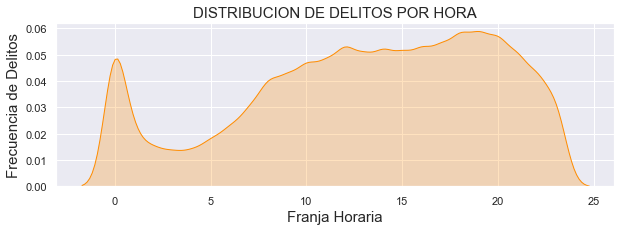

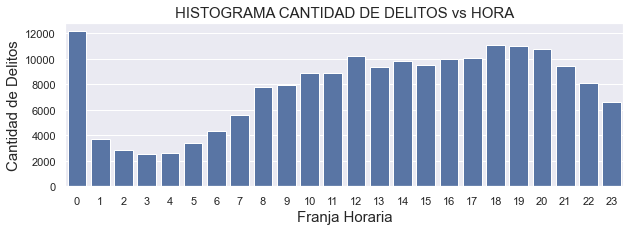

In [29]:
plt.figure(figsize=(10,3))
sns.kdeplot(delitos_total['franja_horaria'], color= "darkorange", shade = True)
plt.xlabel("Franja Horaria",size = 15)
plt.ylabel("Frecuencia de Delitos",size = 15)
plt.title('DISTRIBUCION DE DELITOS POR HORA',size = 15)
plt.show()

plt.figure(figsize=(10,3))
sns.countplot(delitos_total.franja_horaria, color="b")
plt.xlabel("Franja Horaria",size = 15)
plt.ylabel("Cantidad de Delitos",size = 15)
plt.title('HISTOGRAMA CANTIDAD DE DELITOS vs HORA',size = 15)
plt.show()

In [30]:
#mostraremos los delitos por año para analizar el impacto de la pandemia en la ocurrencia de delitos

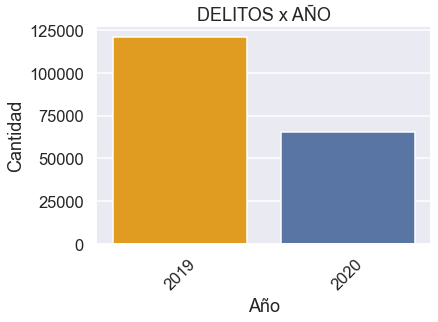

In [31]:
colores2=['orange','b']
sns.set_context("talk")
gr1 = sns.countplot(x='año', data=delitos_total, order=delitos_total.año.value_counts().index, palette=colores2)
plt.ylabel('Cantidad')
plt.xlabel('Año')
plt.xticks(rotation=45)
plt.title("DELITOS x AÑO")
plt.show()

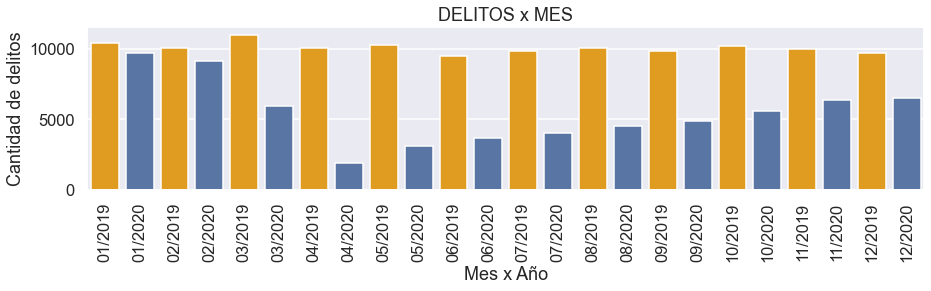

In [32]:
colores3=['orange','b']
plt.figure(figsize=(15,3))
gr1 = sns.countplot(x="mesaño", data=delitos_total, palette=colores3)
plt.ylabel('Cantidad de delitos')
plt.xlabel('Mes x Año')
plt.xticks(rotation=90)
plt.title("DELITOS x MES")
plt.show()


In [33]:
delitos_total['fecha'] = pd.to_datetime(delitos_total['fecha'], format="%d/%m/%Y")

Conclusión parcial: podemos observar que los datos indican una fuerte baja de los delitos durante la pandemia
alrededor de la franja horaria entre 0 y 3. Es probable que la misma haya sido consecuencia del fuerte impacto
que generó la pandemia debido a las restricciones adoptadas en horarios nocturnos. Por su parte, tanto en el año
2019 como en el 2020, la cantidad de delitos por horario tuvo la misma tendencia, siendo que en horarios tempranos
la tasa de delitos es baja, mientras que, por el contrario, a mayor horario nocturno la misma aumenta.


# Delitos vs Tipo

- Visualización y comparación de la dispersión entre los diferentes tipos de delitos. (GRÁFICA SCATTERPLOT)
- Proporción de delitos según su tipo. (GRÁFICO DE TORTA)
- Cantidades de delitos que corresponden a cada tipo

In [34]:
#asignaremos a cada tipo de delito un valor numérico de "gravedad"
delitos_total.loc[(delitos_total['tipo'] == 'Homicidio', 'gravedad')] = 4
delitos_total.loc[(delitos_total['tipo'] == 'Lesiones', 'gravedad')]  = 3
delitos_total.loc[(delitos_total['tipo'] == 'Robo (con violencia)', 'gravedad')] = 2
delitos_total.loc[(delitos_total['tipo'] == 'Hurto (sin violencia)','gravedad')]  = 1

In [35]:
delitos_total.head()

,fecha,franja_horaria,tipo,barrio,comuna,latitud,longitud,mesaño,mes,dia,año,gravedad
81926,2019-01-25,11,Robo (con violencia),PARQUE PATRICIOS,4,-34.636791,-58.403786,01/2019,01,19,2019,2.0
71939,2019-01-18,8,Robo (con violencia),RECOLETA,2,-34.592514,-58.404175,01/2019,01,19,2019,2.0
71940,2019-01-18,15,Robo (con violencia),CHACARITA,15,-34.590628,-58.448602,01/2019,01,19,2019,2.0
71941,2019-01-18,2,Robo (con violencia),PARQUE CHAS,15,-34.588924,-58.478135,01/2019,01,19,2019,2.0
71942,2019-01-18,2,Robo (con violencia),PARQUE CHAS,15,-34.588848,-58.484470,01/2019,01,19,2019,2.0


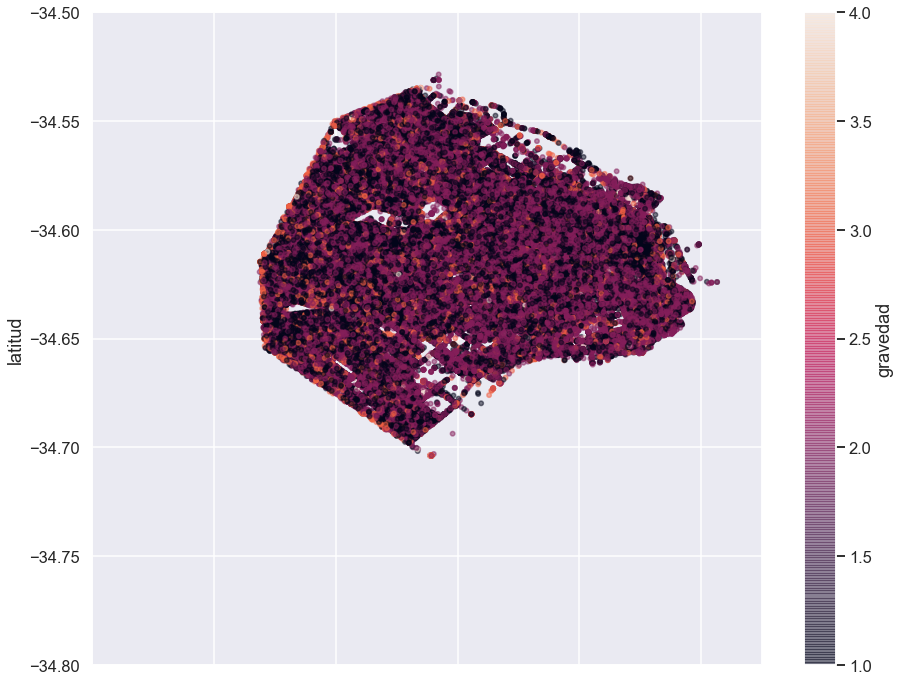

In [36]:
delitos_total.plot(kind='scatter', x='longitud', y='latitud', c='gravedad',
        cmap=plt.get_cmap(), colorbar=True, alpha=0.5, figsize=(15,12))
plt.axis([ -58.6, -58.325, -34.8, -34.5000])
plt.show()

(-58.6, -58.325, -34.8, -34.5)

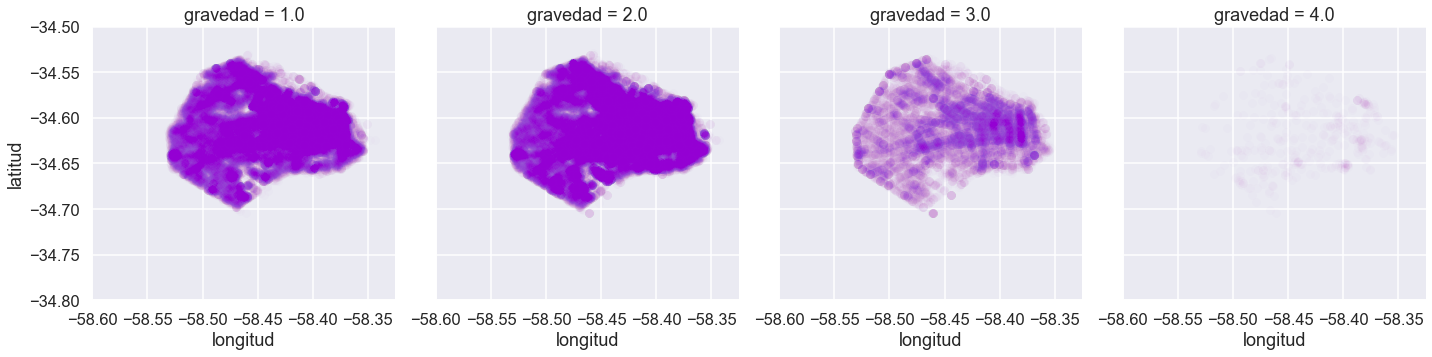

In [37]:
#en el siguiente gráfico se puede ver la densidad de delitos de cada tipo
sns.relplot(x=delitos_total['longitud'], y=delitos_total['latitud'], col='gravedad',
            data=delitos_total, color='darkviolet',alpha=0.01, )

plt.axis([ -58.6, -58.325, -34.8, -34.5000])

<AxesSubplot:ylabel='tipo'>

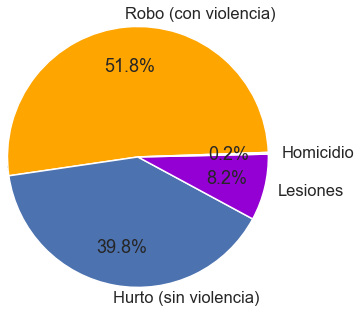

In [38]:
colores=['orange', 'b', 'darkviolet', 'pink']
delitos_total.tipo.value_counts().plot(kind='pie', autopct='%1.1f%%',
                                       startangle=2.0, radius=1.5, center=(0.5, 0.5), 
                                       pctdistance=.7, colors=colores)


In [39]:
delitos_total['tipo'].groupby(delitos_total.tipo).agg('count')

tipo
Homicidio                  384
Hurto (sin violencia)    74218
Lesiones                 15348
Robo (con violencia)     96494
Name: tipo, dtype: int64

Conclusión parcial: en este caso concluímos que, tomando en consideración ambos años, el delito con mayor cantidad fue el catalogado como Robo (con violencia), lo cual indica el alto grado de peligrosidad en Argentina, más precisamente en CABA. Luego, es seguido por el Hurto (sin violencia), quedando rezagados tanto las lesiones como los homicidios aunque no menos importante. Esto último queda en evidencia al ver las densidades de los delitos por cada tipo en cada uno de los mapas, donde nos muestra que los robos y hurtos son muy comunes en el día a día en la ciudad.

# Delitos vs Barrio

- Creación de gráfica de la cantidad de delitos según el barrio donde ocurrió. (GRÁFICO DE BARRAS)
- Creación de gráfica de la proporción de delitos según la población pertinente a cada barrio. (GRÁFICO DE BARRAS)
- Comparación entre ambas gráficas.

A continuación veremos la cantidad de delitos por barrio sin considerar otras variables intrínsecas a los mismos como la cantidad de habitantes.

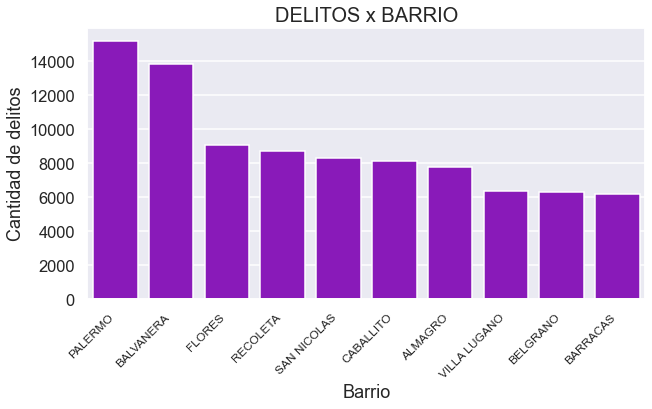

In [40]:
top_barrio1 = delitos_total['barrio'].value_counts().index[0:10]

plt.figure(figsize=(10,5))
g = sns.countplot(x='barrio',data=delitos_total, color = "darkviolet",order=top_barrio1)
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha="right",size = 12)
plt.title('DELITOS x BARRIO',size = 20)
plt.xlabel("Barrio")
plt.ylabel("Cantidad de delitos")
plt.show()

In [41]:
#importamos el dataset que contiene el número de población por barrio
barrios = pd.read_csv('/Users\etchanchum\Documents\Python Agus/pob_barrios.csv')

In [42]:
barrios.head()

,BARRIO,POBLACION
0,AGRONOMIA,13912
1,ALMAGRO,131699
2,BALVANERA,138926
3,BARRACAS,89452
4,BELGRANO,126267


In [43]:
dxbarrio = delitos_total.barrio.value_counts()
dxbarrio = dxbarrio.reset_index()
dxbarrio = pd.DataFrame(dxbarrio)

In [44]:
dxbarrio = dxbarrio.rename(columns={'index':'BARRIO','barrio':'delitos por barrio'})
dxbarrio.head()

,BARRIO,delitos por barrio
0,PALERMO,15223
1,BALVANERA,13848
2,FLORES,9064
3,RECOLETA,8750
4,SAN NICOLAS,8342


In [45]:
dens_pob = pd.merge(barrios, dxbarrio, how='outer', left_on=barrios['BARRIO'], right_on=dxbarrio['BARRIO'])
dens_pob['Densidad delitos'] = dens_pob['delitos por barrio'] / dens_pob['POBLACION']

In [46]:
dens_pob = dens_pob.sort_values(by='Densidad delitos',ascending=False) 

In [47]:
dens_pob.drop(['BARRIO_x', 'BARRIO_y'], axis = 'columns', inplace=True)
dens_pob = dens_pob.rename(columns={'key_0':'barrio'})
dens_pob = dens_pob.rename(columns={'POBLACION':'poblacion'})
dens_pob = dens_pob.rename(columns={'delitos por barrio':'delitos_barrio'})
dens_pob = dens_pob.rename(columns={'Densidad delitos':'densidad_delitos'})

In [48]:
dens_pob.head()

,barrio,poblacion,delitos_barrio,densidad_delitos
31,SAN NICOLAS,29273,8342,0.284973
11,CONSTITUCION,44107,5603,0.127032
16,MONSERRAT,39914,4672,0.117052
32,SAN TELMO,20453,2281,0.111524
18,NUEVA POMPEYA,42695,4456,0.104368


In [49]:
dens_pob.dtypes

barrio               object
poblacion             int64
delitos_barrio        int64
densidad_delitos    float64
dtype: object

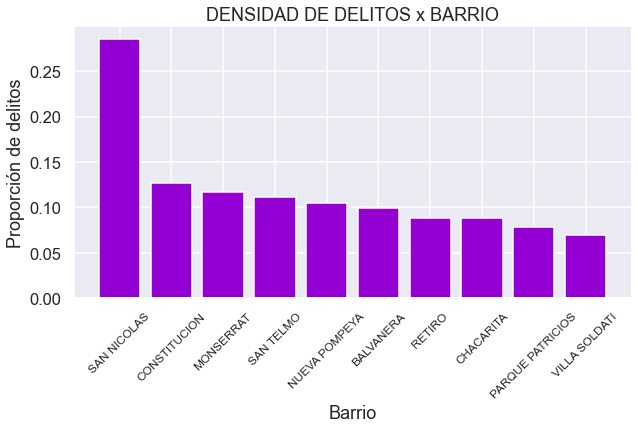

In [50]:
plt.figure(figsize=(10,5))
plt.bar(dens_pob.barrio[0:10], dens_pob.densidad_delitos[0:10],color='darkviolet')
plt.xticks(rotation=45, size=12)
plt.title('DENSIDAD DE DELITOS x BARRIO')
plt.xlabel('Barrio')
plt.ylabel('Proporción de delitos')
plt.show()

Conclusión parcial: los datos identifican al barrio de Palermo como el de mayor cantidad de delitos, y por lo tanto, 
suponer que es el más peligroso. Creemos que este termino es erroneo debido a que el mismo presenta la población y 
el perímetro más grande de la ciudad. Por ello, la cantidad de delitos por barrio fue afectada por el factor 
poblacional de cada uno de ellos, dando como resultado que la mayor cantidad de delitos por persona es cometida en el barrio de San Nicolas, aunque la determinación del barrio más peligroso depende de muchos factores que no se están teniendo en cuenta (cercanía de comisarías, presencia policial, barrios carenciados, etc), por lo que no debe ser clasificado como tal.